<a href="https://colab.research.google.com/github/it20648404/DL_LAB_005/blob/main/Autonomous_driving_application_car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autonomous driving - Car detection

Welcome to your week 3 programming assignment. You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242).

**You will learn to**:
- Use object detection on a car detection dataset
- Deal with bounding boxes

Run the following cell to load the packages and dependencies that are going to be useful for your journey!

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To simplify the loading of files and folders, we can load all files and directories from a zip file in google drive.

In [61]:
!unzip '/content/drive/MyDrive/DL_LAB/lab_5.zip'  #Change the zip file name as needed

Archive:  /content/drive/MyDrive/DL_LAB/lab_5.zip
   creating: lab_5/
   creating: lab_5/font/
  inflating: lab_5/font/FiraMono-Medium.otf  
  inflating: lab_5/font/SIL+Open+Font+License.txt  
   creating: lab_5/images/
  inflating: lab_5/images/0100.jpg   
  inflating: lab_5/images/0101.jpg   
  inflating: lab_5/images/0102.jpg   
  inflating: lab_5/images/0103.jpg   
  inflating: lab_5/images/0104.jpg   
  inflating: lab_5/images/0105.jpg   
  inflating: lab_5/images/0106.jpg   
  inflating: lab_5/images/0107.jpg   
  inflating: lab_5/images/0108.jpg   
  inflating: lab_5/images/0109.jpg   
  inflating: lab_5/images/0110.jpg   
  inflating: lab_5/images/0111.jpg   
  inflating: lab_5/images/0112.jpg   
  inflating: lab_5/images/0113.jpg   
  inflating: lab_5/images/0114.jpg   
  inflating: lab_5/images/0115.jpg   
  inflating: lab_5/images/0116.jpg   
  inflating: lab_5/images/0117.jpg   
  inflating: lab_5/images/0118.jpg   
  inflating: lab_5/images/0119.jpg   
  inflating: lab_5/i

In [62]:
#!pip list

In [63]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
# from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()


**Important Note**: As you can see, we import Keras's backend as K. This means that to use a Keras function in this notebook, you will need to write: `K.function(...)`.

## 1 - Problem Statement

You are working on a self-driving car. As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around.

<center>
<video width="400" height="200" src="https://github.com/enggen/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We would like to especially thank [drive.ai](https://www.drive.ai/) for providing this dataset! Drive.ai is a company building the brains of self-driving vehicles.
</center></caption>

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/driveai.png" style="width:100px;height:100;">

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use.

## 2 - YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 2.1 - Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers.

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture:

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm.


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps:
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold.

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator:
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score ([Hint](https://keras.io/backend/#argmax)) (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score ([Hint](https://keras.io/backend/#max)) (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep.
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. ([Hint](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))

Reminder: to call a Keras function, you should use `K.function(...)`.

In [64]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.

    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box

    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold.
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs # (19, 19, 5, 80)
    ### END CODE HERE ###

    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis=-1)  # (19, 19, 5)
    box_class_scores = K.max(box_scores, axis=-1) # (19, 19, 5)
    ### END CODE HERE ###

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores >= threshold  # (19, 19, 5)
    # print(filtering_mask.shape)
    # print(box_class_scores.shape)
    ### END CODE HERE ###

    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    print (scores,boxes, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###

    return scores, boxes, classes

In [65]:
with tf.compat.v1.Session() as test_a:
    box_confidence = tf.compat.v1.random_normal([19, 19, 5, 1], mean=0.1, stddev=0.1, seed = 1)
    boxes = tf.compat.v1.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.compat.v1.random_normal([19, 19, 5, 80], mean=0.1, stddev=0.1, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.1)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))
    print(boxes.eval().shape)

Tensor("boolean_mask_96/GatherV2:0", shape=(None,), dtype=float32) Tensor("random_normal_98:0", shape=(19, 19, 5, 4), dtype=float32) Tensor("GreaterEqual_32:0", shape=(19, 19, 5), dtype=bool)
scores[2] = 0.1053769
boxes[2] = [-4.881134 -4.703688  4.888174 -3.484911]
classes[2] = 24
scores.shape = (None,)
boxes.shape = (None, 4)
classes.shape = (None,)
(50, 4)


In [66]:
# box_confidence = tf.compat.v1.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
# boxes = tf.compat.v1.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
# box_class_probs = tf.compat.v1.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
# scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)

# # Start an interactive session
# sess = tf.compat.v1.InteractiveSession()
# print("boxes[2] = " + str(boxes[2].eval()))
# sess.close()

**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           10.7506
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           7
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (?,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (?, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (?,)
        </td>
    </tr>

</table>

### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS).

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 7** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 8** </u>: Definition of "Intersection over Union". <br> </center></caption>

**Exercise**: Implement iou(). Some hints:
- In this exercise only, we define a box using its two corners (upper left and lower right): `(x1, y1, x2, y2)` rather than the midpoint and height/width.
- To calculate the area of a rectangle you need to multiply its height `(y2 - y1)` by its width `(x2 - x1)`.
- You'll also need to find the coordinates `(xi1, yi1, xi2, yi2)` of the intersection of two boxes. Remember that:
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
- In order to compute the intersection area, you need to make sure the height and width of the intersection are positive, otherwise the intersection area should be zero. Use `max(height, 0)` and `max(width, 0)`.

In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner.

In [67]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(yi2-yi1, 0) * max(xi2-xi1, 0)
    ### END CODE HERE ###

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1]) *  (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) *  (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###

    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###

    return iou

In [68]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


**Expected Output**:

<table>
    <tr>
        <td>
            **iou = **
        </td>
        <td>
           0.14285714285714285
        </td>
    </tr>

</table>

You are now ready to implement non-max suppression. The key steps are:
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: Implement yolo_non_max_suppression() using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):
- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
- [K.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)

In [69]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes

    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box

    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.compat.v1.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    # print(nms_indices)
    ### END CODE HERE ###

    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###

    return scores, boxes, classes ,nms_indices

In [70]:
with tf.compat.v1.Session() as test_b:
    scores = tf.compat.v1.random_normal([54,], mean=1, stddev=4, seed = 1) #testing with only 54 boxes vector
    boxes = tf.compat.v1.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.compat.v1.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes, indices_b = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("indices of boxes = " + str(indices_b.eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
indices of boxes = [49 46 30 18 14 21 39  7 15  0]
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           6.9384
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [-5.299932    3.13798141  4.45036697  0.95942086]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           -2.24527
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (10, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

### 2.4 Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented.

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided):

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh)
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

Don't worry about these two functions; we'll show you where they need to be called.  

In [116]:
# GRADED FUNCTION: yolo_eval
#score threshold default 0.6
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=0.6, iou_threshold=.7):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.

    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    ### START CODE HERE ###

    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes, __ = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    ### END CODE HERE ###

    return scores, boxes, classes

In [117]:
with tf.compat.v1.Session() as test_b:
    yolo_outputs = (tf.compat.v1.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

Tensor("boolean_mask_117/GatherV2:0", shape=(None,), dtype=float32) Tensor("concat_8:0", shape=(19, 19, 5, 4), dtype=float32) Tensor("GreaterEqual_39:0", shape=(19, 19, 5), dtype=bool)
scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           138.791
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [ 1292.32971191  -278.52166748  3876.98925781  -835.56494141]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           54
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (10, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

<font color='blue'>
**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers.
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture.
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output.

## 3 - Test YOLO pretrained model on images

In this part, you are going to use a pretrained model and test it on the car detection dataset. As usual, you start by **creating a session to start your graph**. Run the following cell.

In [118]:
#import keras.backend as K

sess = K.get_session()

### 3.1 - Defining classes, anchors and image shape.

Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell.

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images.

In [119]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

### 3.2 - Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pretrained Keras YOLO model stored in "yolo.h5". (These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will more simply refer to it as "YOLO" in this notebook.) Run the cell below to load the model from this file.

In [120]:
yolo_model = load_model("model_data/yolo_v2.h5")

This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [121]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

**Note**: On some computers, you may see a warning message from Keras. Don't worry about it if you do--it is fine.

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

### 3.3 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.

In [122]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by your `yolo_eval` function.

### 3.4 - Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this.

In [123]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Tensor("boolean_mask_120/GatherV2:0", shape=(None,), dtype=float32) Tensor("concat_9:0", shape=(None, None, None, 5, 4), dtype=float32) Tensor("GreaterEqual_40:0", shape=(None, None, None, 5), dtype=bool)


### 3.5 - Run the graph on an image

Let the fun begin. You have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

**Exercise**: Implement predict() which runs the graph to test YOLO on an image.
You will need to run a TensorFlow session, to have it compute `scores, boxes, classes`.

The code below also uses the following function:
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
- image_data: a numpy-array representing the image. This will be the input to the CNN.

**Important note**: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict {K.learning_phase(): 0}.

In [124]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.

    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.

    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes

    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes.
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    feed_dict={ yolo_model.input: image_data, K.learning_phase(): 0 }
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores, boxes, classes], feed_dict=feed_dict)
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    #output_image = scipy.misc.imread(os.path.join("out", image_file))
    import imageio
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
bus 0.67 (5, 267) (220, 407)
car 0.68 (705, 279) (786, 351)
car 0.70 (947, 324) (1280, 704)
car 0.75 (159, 303) (346, 440)
car 0.80 (762, 282) (942, 412)
car 0.89 (366, 299) (745, 648)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


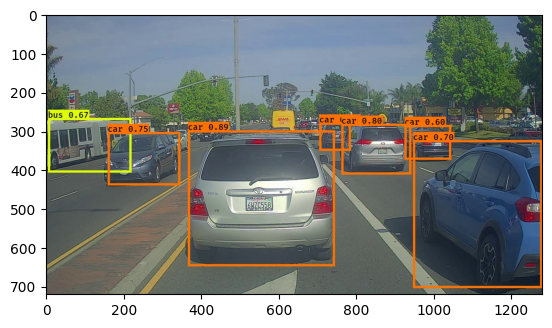

In [125]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

**Expected Output**:

<table>
    <tr>
        <td>
            **Found 7 boxes for test.jpg**
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.60 (925, 285) (1045, 374)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.66 (706, 279) (786, 350)
        </td>
    </tr>
    <tr>
        <td>
            **bus**
        </td>
        <td>
           0.67 (5, 266) (220, 407)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.70 (947, 324) (1280, 705)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.74 (159, 303) (346, 440)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.80 (761, 282) (942, 412)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.89 (367, 300) (745, 648)
        </td>
    </tr>
</table>

Output for some random images

Found 4 boxes for DSC_1643_resized.jpg
car 0.63 (779, 424) (894, 497)
car 0.72 (423, 399) (590, 534)
car 0.74 (783, 403) (893, 486)
car 0.77 (641, 402) (726, 476)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


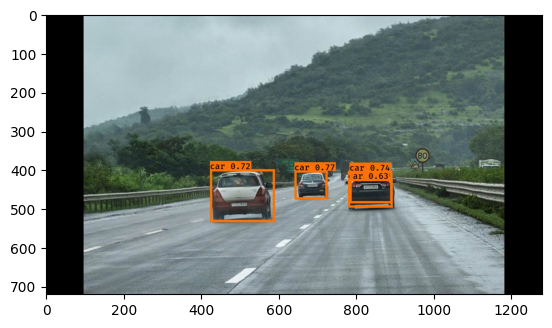

In [126]:
out_scores, out_boxes, out_classes = predict(sess, "DSC_1643_resized.jpg")

Found 2 boxes for giraffe_resized.jpg
zebra 0.87 (687, 305) (903, 637)
giraffe 0.88 (500, 26) (907, 568)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


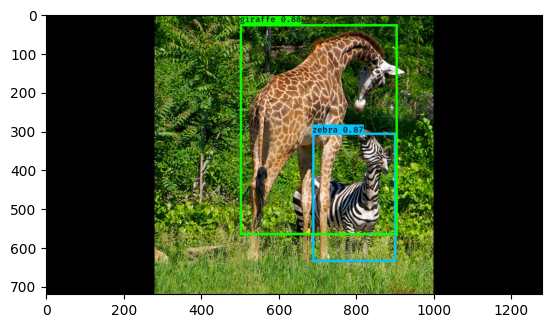

In [127]:
out_scores, out_boxes, out_classes = predict(sess, "giraffe_resized.jpg")

Found 2 boxes for tr.jpg
traffic light 0.66 (599, 160) (655, 268)
car 0.71 (533, 546) (758, 582)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


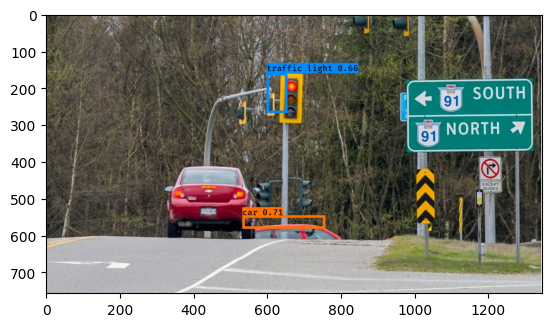

In [128]:
out_scores, out_boxes, out_classes = predict(sess, "tr.jpg")

Detect objects in all autonomous driving dataset images (i.e., 0100.jpg - 0120.jpg) in the images directory

Found 0 boxes for 0108.jpg


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0112.jpg
Found 0 boxes for 0113.jpg
Found 0 boxes for 0100.jpg
Found 0 boxes for 0120.jpg
Found 1 boxes for 0119.jpg
traffic light 0.61 (1056, 0) (1138, 131)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0117.jpg
Found 2 boxes for 0111.jpg
car 0.61 (97, 322) (180, 366)
fire hydrant 0.64 (1177, 374) (1237, 483)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 1 boxes for 0102.jpg
bus 0.79 (180, 259) (304, 362)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0118.jpg
Found 1 boxes for 0107.jpg
car 0.61 (376, 309) (421, 335)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0109.jpg
Found 1 boxes for 0106.jpg
car 0.62 (1200, 287) (1276, 432)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 1 boxes for 0103.jpg
bus 0.75 (0, 286) (203, 420)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0114.jpg
Found 0 boxes for 0110.jpg
Found 2 boxes for 0104.jpg
traffic light 0.61 (241, 24) (273, 97)
truck 0.82 (0, 223) (291, 421)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0101.jpg
Found 2 boxes for 0116.jpg
traffic light 0.63 (522, 76) (543, 113)
car 0.80 (5, 271) (241, 671)


<ipython-input-124-7df821f68001>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  output_image = imageio.imread(os.path.join("out", image_file))


Found 0 boxes for 0115.jpg
Found 0 boxes for 0105.jpg


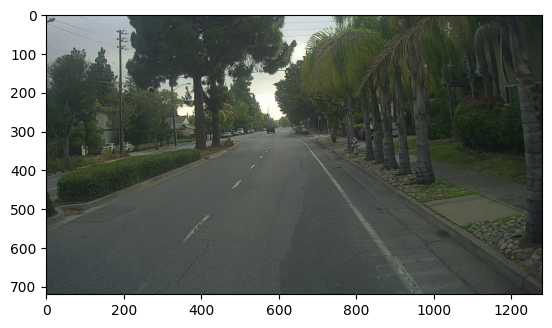

In [129]:
new_path = '/content/images'
for file_name in os.listdir(new_path):
  if file_name[0] == '0': # images from [ 0100.jpg , 0120.jpg ]
    out_scores, out_boxes, out_classes = predict(sess, file_name)

Zip all output images and save the zip file to a folder in google drive for later use

In [130]:
import os
import zipfile
import shutil

directory = '/content/out'
zip_filename = '/content/out_score_0.6_iou_0.5_.zip'
dest_folder = '/content/drive/MyDrive/DL_LAB'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    [zipf.write(os.path.join(directory, f), f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

os.makedirs(dest_folder, exist_ok=True)
shutil.copy2(zip_filename, dest_folder)

'/content/drive/MyDrive/DL_LAB/out_score_0.6_iou_0.5_.zip'

The model you've just run is actually able to detect 80 different classes listed in "coco_classes.txt". To test the model on your own images:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the cell above code
    4. Run the code and see the output of the algorithm!

If you were to run your session in a for loop over all your images. Here's what you would get:

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Predictions of the YOLO model on pictures taken from a camera while driving around the Silicon Valley <br> Thanks [drive.ai](https://www.drive.ai/) for providing this dataset! </center></caption>

<font color='blue'>
**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume.
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically:
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise.

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website.
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are especially grateful to Brody Huval, Chih Hu and Rahul Patel for collecting and providing this dataset.